# Plot search metrics and other dynamical measures as a function of one or more filament parameters

In [3]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pyfilaments.analysisutils as analysis
import pandas as pd
import h5py

from joblib import Parallel, delayed
import multiprocessing
%matplotlib notebook
plt.close('all')

# Figure parameters
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import cm
from tqdm import tqdm

rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 14})

# Create a folder for storing Publication figures

publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures'


# Set the values for the publication figure parameters
rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 14})
sns.set(font_scale = 1)

dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', 're', 'enum', 

In [4]:
# Specify folder which to analyze

data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep']

In [5]:
# Find all analysis data files and create a list
files_list = []
 # Walk through the folders and identify the simulation data files

for data_folder in data_folders:
    for dirs, subdirs, files in os.walk(data_folder, topdown=False):

        root, subFolderName = os.path.split(dirs)

        for fileNames in files:
            if(fileNames.endswith('csv') and fileNames[0] != '.' and 'analysis' in fileNames and 'ic' not in fileNames):
                files_list.append(os.path.join(dirs,fileNames))


print('No:of files: {}'.format(len(files_list)))

# Collect all data into a single data frame
df = pd.DataFrame({})

for file in files_list:
    
    df = df.append(pd.read_csv(file))
    

    
df['periodic dynamics'][df['periodic dynamics']==1] = True
df['periodic dynamics'][df['periodic dynamics']==0] = False
df['period'][pd.isna(df['period'])] = 'aperiodic'
df['period'][df['simulation completed']== False] = 'Escape'
df

No:of files: 620


/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,N particles,radius,bond length,spring constant,kappa_hat,force strength,stresslet strength,potDipole strength,simulation type,boundary condition 0,boundary condition 1,activity time scale,viscosity,period,simulation completed,periodic dynamics,max unique locations,activity cycles completed
0,0,32,1,2.1,25,6.25,0,0,3.256410,point,clamped,free,750,0.166667,aperiodic,True,False,1245.0,500
0,0,32,1,2.1,25,6.25,0,0,3.256410,point,clamped,free,750,0.166667,aperiodic,True,False,1171.0,500
0,0,32,1,2.1,25,6.25,0,0,3.256410,point,clamped,free,750,0.166667,aperiodic,True,False,1225.0,500
0,0,32,1,2.1,25,6.25,0,0,5.371795,point,clamped,free,750,0.166667,aperiodic,True,False,985.0,500
0,0,32,1,2.1,25,6.25,0,0,5.371795,point,clamped,free,750,0.166667,aperiodic,True,False,984.0,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,32,1,2.1,25,6.25,0,0,0.564103,point,clamped,free,750,0.166667,1,True,True,1.0,500
0,0,32,1,2.1,25,6.25,0,0,0.564103,point,clamped,free,750,0.166667,1,True,True,1.0,500
0,0,32,1,2.1,25,6.25,0,0,1.076923,point,clamped,free,750,0.166667,aperiodic,True,False,21.0,500
0,0,32,1,2.1,25,6.25,0,0,1.076923,point,clamped,free,750,0.166667,aperiodic,True,False,23.0,500


## Plot Max unique locations sampled vs Activity strength

<IPython.core.display.Javascript object>


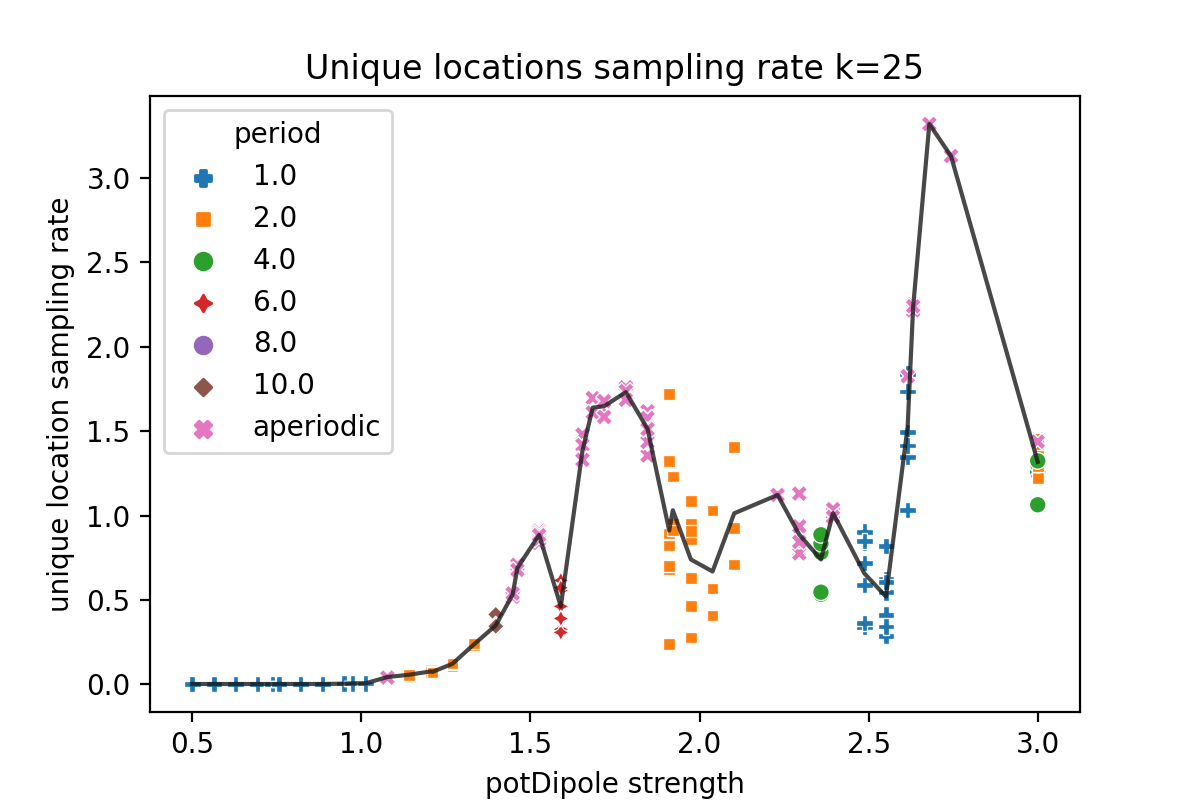

In [8]:
parameter = 'potDipole strength'
save = False

# Take subset of data for which simulation was completed
df_subset = df.loc[df['simulation completed']==True]

df_subset = df_subset.loc[df_subset[parameter]<=3.0]

plt.style.use('default')

df_subset['unique location sampling rate'] = df_subset['max unique locations']/df_subset['activity cycles completed']


title = 'Unique locations sampling rate k={}'.format(np.array(df['spring constant'][:])[0])
plt.figure(figsize=(6, 4))
# ax = sns.lineplot(data=df, x= 'potDipole strength', y= 'max unique locations', ci=None, markers=False, dashes = False, color = 'k')

# ax1 = sns.lineplot(data=df_subset, x= 'potDipole strength', y= 'unique location sampling rate', style=" activity time scale", markers=None, ci=95, err_style = 'bar', err_kws= {'capsize':3, 'elinewidth':1, 'ecolor':'r'}, markerfacecolor='r', markeredgecolor='w', color = 'k', alpha =0.8, legend = False)
ax1 = sns.lineplot(data=df_subset, x= parameter, y= 'unique location sampling rate', style=" activity time scale", markers=None, ci=None, err_style = 'band', markerfacecolor='r', markeredgecolor='w', color = 'k', alpha =0.8, legend = False)

ax2 = sns.scatterplot(data=df_subset, x= parameter, y= 'unique location sampling rate', style="period", hue = 'period', hue_order = [1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 'aperiodic'])


# ax.set_xscale('log')
plt.title(title)

if (save):
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.show()

## Compare full simulations with Predicted Dynamics

<IPython.core.display.Javascript object>


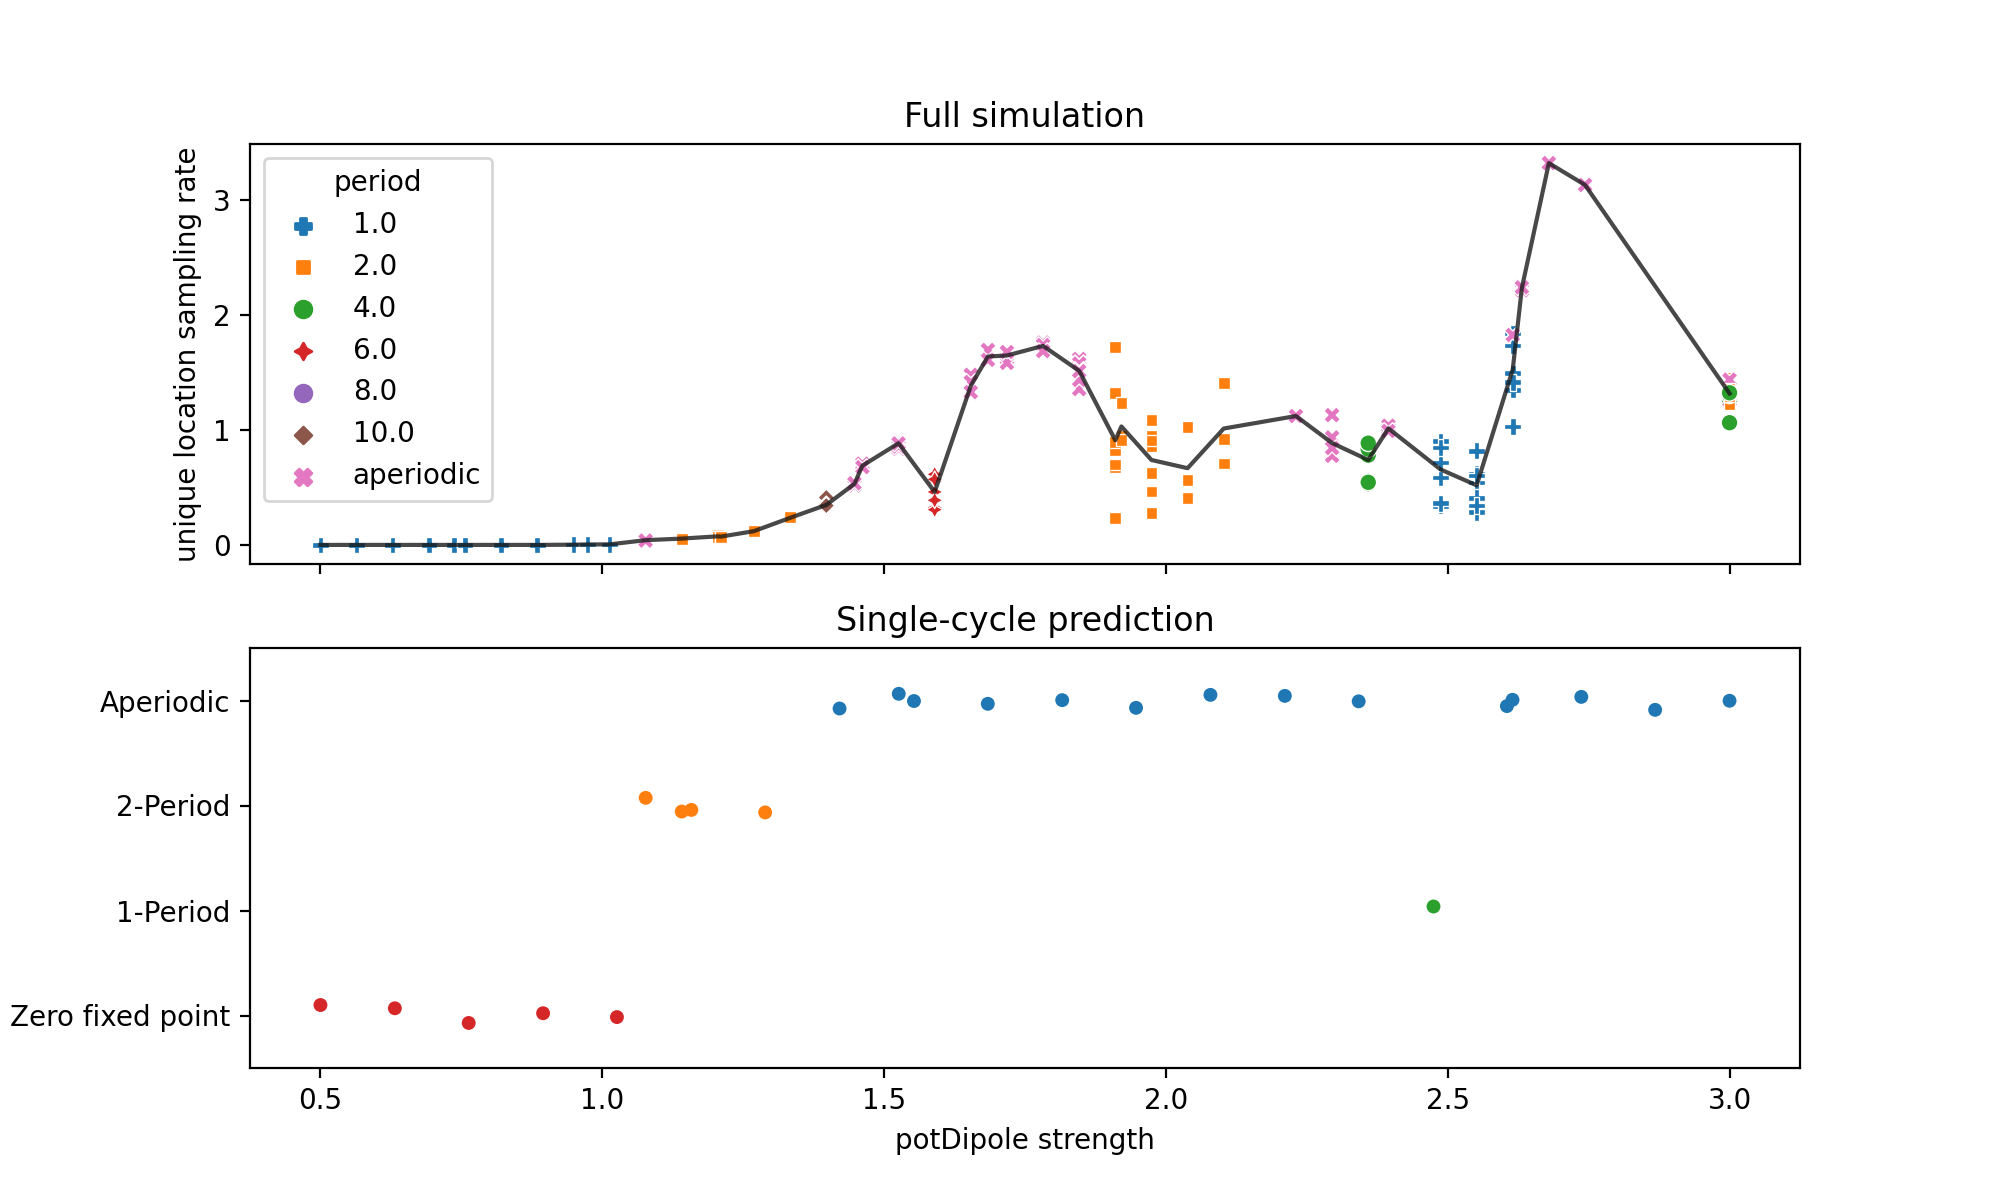

In [18]:
save = True 

predicted_dynamics = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_k_25_extension_first/PredictedDynamics/PredictedDynamics.csv'

df_predicted_dynamics = pd.read_csv(predicted_dynamics)

fig,(ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (10,6))
title = 'FullSimVsPredictedDynamics'
sns.lineplot(data=df_subset, x= parameter, y= 'unique location sampling rate', style=" activity time scale", 
             markers=None, ci=None, err_style = 'band', markerfacecolor='r', markeredgecolor='w', 
             color = 'k', alpha =0.8, legend = False, ax = ax0)

sns.scatterplot(data=df_subset, x= parameter, y= 'unique location sampling rate', style="period", 
                hue = 'period', hue_order = [1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 'aperiodic'], ax = ax0)

sns.stripplot(data = df_predicted_dynamics, x = parameter, y = 'Predicted dynamics', 
            order=["Aperiodic", "2-Period", "1-Period", "Zero fixed point"], ax = ax1)

ax0.title.set_text('Full simulation')
ax1.title.set_text('Single-cycle prediction')

# plt.title(title)

if (save):
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.show()



